## Requirements

Please install cuda on your device if you have a GPU available.  
This line in the miniconda prompt worked for me: conda install -c conda-forge cudatoolkit=11.2 cudnn=8.1.0  
You can refer to this: https://stackoverflow.com/questions/45662253/can-i-run-keras-model-on-gpu  
And also this: https://www.tensorflow.org/install/pip#linux

## Imports

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0" # Makes visible cuda devices, -1 otherwise

GOOGLE_COLAB = 0 # 1 if you are on google colab, 0 for local machine

In [2]:
# The following two lines are only necessayr if you work on google colab
if GOOGLE_COLAB:
    from google.colab import drive
    print(2)
    drive.mount('/content/drive')

import multiprocessing
num_cpus = multiprocessing.cpu_count()
print(f"Number of CPUs: {num_cpus}")

Number of CPUs: 8


In [3]:
if GOOGLE_COLAB:
    !pip install scikit-learn==1.3.2

In [4]:
from helpers import *
from models import *

import numpy as np
import cv2

import math
import random


import skimage.io as io
import skimage.transform as trans

from tqdm import tqdm

from sklearn.model_selection import train_test_split

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf

In [5]:
# This will print logs and cannot be disabled (except restart). Run only to check that GPU is enabled
#tf.debugging.set_log_device_placement(True)

In [6]:
# Make use of GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# with tf.device('/cpu:0'): Force CPU utilization instead of GPU
# This code should run on the GPU, you can see it by uncommenting the code in the previous cell
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)
print(c)

Num GPUs Available:  0
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


## Constants

In [7]:
%run models.py # If you have error of XXX not found below, try this
%run helpers.py

In [8]:
TRAIN_DIRECTORY_PATH = 'base_training/'
TRAIN_IMAGES_PATH = TRAIN_DIRECTORY_PATH + 'images/'
TRAIN_GROUNDTRUTH_PATH = TRAIN_DIRECTORY_PATH + 'groundtruth/'

TEST_DIRECTORY_PATH = 'test_set_images/'
TEST_IMAGES_PATH = [TEST_DIRECTORY_PATH + "test_" + str(i) + "/" for i in range(1,51)]

PATCH_SIZE = 96
NUMBER_NEW_TRAINING_TO_TAKE = 0 # Used
NUMBER_CHANNELS_INPUT = 3
BATCH_SIZE = 64 # Put 16 to avoid burning your laptop

MODEL_FUNCTION = UEfficientNet # Just implement your model in models.py and change this
MODEL = MODEL_FUNCTION((PATCH_SIZE, PATCH_SIZE, NUMBER_CHANNELS_INPUT), verbose = False)

CHECKPOINT_PATH = "check_points/" + str(MODEL_FUNCTION.__name__)
SAVE_MODEL_PATH = "models/" + str(MODEL_FUNCTION.__name__) + ".h5"

RANDOM = np.random.randint(69)

tf.random.set_seed(RANDOM)

Shape of output_layer: (None, 96, 96, 1)


In [9]:
# Load model from local models folder
#MODEL = tf.keras.models.load_model(SAVE_MODEL_PATH, custom_objects={'get_f1': get_f1})

## Load data

### Train

In [10]:
train_images = []
train_labels = []
threshold = 0.5
# Load the train images from the TRAIN_IMAGES_PATH
for file in tqdm(os.listdir(TRAIN_IMAGES_PATH), total=len(os.listdir(TRAIN_IMAGES_PATH))):

    if os.path.isdir(file):
        continue

    img = plt.imread(TRAIN_IMAGES_PATH + file)
    label = plt.imread(TRAIN_GROUNDTRUTH_PATH + file)
    img_split = split_into_patches(img, PATCH_SIZE)
    label= round_groundtruth(label, threshold)
    label_split = split_into_patches(label, PATCH_SIZE)
    train_images.append(img_split)
    train_labels.append(label_split)

train_images = np.array(train_images)
train_labels = np.array(train_labels)
# Below, this merges the first two dimensions. Instead of having x elements of y patches, we have x*y patches.
train_images = combine_dims(train_images, start = 0, count = 2)
train_labels = combine_dims(train_labels, start = 0, count = 2)
train_labels = train_labels[:, :, :, np.newaxis]
print(f'Base train shape: {train_images.shape}')
print(train_labels.shape)

100%|███████████████████████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 110.04it/s]


Base train shape: (2500, 96, 96, 3)
(2500, 96, 96, 1)


In [11]:
""" train_images = []

for file in tqdm(os.listdir(TRAIN_IMAGES_PATH), total=len(os.listdir(TRAIN_IMAGES_PATH))):
    
    if os.path.isdir(file):
        continue
    
    img = plt.imread(TRAIN_IMAGES_PATH + file)
    img_split = split_into_patches(img, PATCH_SIZE)
    train_images.append(img_split)


train_images = np.array(train_images)

# Below, this merges the first two dimensions. Instead of having x elements of y patches, we have x*y patches.
train_images = combine_dims(train_images, start = 0, count = 2)
print(f'Base train shape: {train_images.shape}')
 """

" train_images = []\n\nfor file in tqdm(os.listdir(TRAIN_IMAGES_PATH), total=len(os.listdir(TRAIN_IMAGES_PATH))):\n    \n    if os.path.isdir(file):\n        continue\n    \n    img = plt.imread(TRAIN_IMAGES_PATH + file)\n    img_split = split_into_patches(img, PATCH_SIZE)\n    train_images.append(img_split)\n\n\ntrain_images = np.array(train_images)\n\n# Below, this merges the first two dimensions. Instead of having x elements of y patches, we have x*y patches.\ntrain_images = combine_dims(train_images, start = 0, count = 2)\nprint(f'Base train shape: {train_images.shape}')\n "

In [12]:
""" threshold = 0.5
train_labels = []

for file in tqdm(os.listdir(TRAIN_GROUNDTRUTH_PATH),total=len(os.listdir(TRAIN_GROUNDTRUTH_PATH))):
    
    if os.path.isdir(file):
        continue
    
    img = plt.imread(TRAIN_GROUNDTRUTH_PATH + file)
    #img = round_groundtruth(img, threshold) # Uncomment to round the groundtruth
    img_split = split_into_patches(img, PATCH_SIZE)
    train_labels.append(img_split)
    
train_labels = np.array(train_labels)

train_labels = combine_dims(train_labels, start = 0, count = 2)
# Below, this adds a dimension at the end, such that the image is of size x*x*1, where 1 is the grayscale value of the pixel
train_labels = train_labels[:, :, :, np.newaxis]

print(train_labels.shape) """

' threshold = 0.5\ntrain_labels = []\n\nfor file in tqdm(os.listdir(TRAIN_GROUNDTRUTH_PATH),total=len(os.listdir(TRAIN_GROUNDTRUTH_PATH))):\n    \n    if os.path.isdir(file):\n        continue\n    \n    img = plt.imread(TRAIN_GROUNDTRUTH_PATH + file)\n    #img = round_groundtruth(img, threshold) # Uncomment to round the groundtruth\n    img_split = split_into_patches(img, PATCH_SIZE)\n    train_labels.append(img_split)\n    \ntrain_labels = np.array(train_labels)\n\ntrain_labels = combine_dims(train_labels, start = 0, count = 2)\n# Below, this adds a dimension at the end, such that the image is of size x*x*1, where 1 is the grayscale value of the pixel\ntrain_labels = train_labels[:, :, :, np.newaxis]\n\nprint(train_labels.shape) '

### Test

In [13]:
test_images = []
test_ids = []
        
for directory in tqdm(TEST_IMAGES_PATH, total=len(TEST_IMAGES_PATH)):
    for file in os.listdir(directory):
        test_ids.append(file)
        img = plt.imread(directory + file)
        img_split = split_into_patches(img, PATCH_SIZE)
        test_images.append(img_split)

test_images = np.array(test_images)
# Below, this merges the first two dimensions. Instead of having x elements of y patches, we have x*y patches.
test_images = combine_dims(test_images, start = 0, count = 2)
print(test_images.shape)

test_ids = [x.split(".")[0] for x in test_ids]

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 55.64it/s]

(2450, 96, 96, 3)


### Split for validation

In [14]:
if GOOGLE_COLAB:
    test_size = 0.20
    train_size = 1 - test_size
    X_train = train_images[:int(train_images.shape[0]*train_size)]
    y_train = train_labels[:int(train_images.shape[0]*train_size)]
    X_test = train_images[int(train_images.shape[0]*train_size):]
    y_test = train_labels[int(train_images.shape[0]*train_size):]
else:
    X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels, test_size = 0.20, random_state = RANDOM)

print(X_train.shape)

(2000, 96, 96, 3)


## Call model

In [16]:
save_interval = 50

if MODEL_FUNCTION.__name__ == 'fat_unet':
        callbacks = [
                tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
                tf.keras.callbacks.TensorBoard(log_dir='logs'),
                tf.keras.callbacks.ModelCheckpoint(filepath=CHECKPOINT_PATH, save_weights_only=True, verbose=1, save_best_only=True)]
elif MODEL_FUNCTION.__name__ == 'UEfficientNet':
        callbacks = [
                tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
                tf.keras.callbacks.TensorBoard(log_dir='logs'),
                CustomModelCheckpoint(checkpoint_path=CHECKPOINT_PATH, save_interval=save_interval)]

In [ ]:
#MODEL = tf.keras.models.load_model(BEST_MODEL_PATH, custom_objects={'get_f1': get_f1}) # Once you run the model once, you can train more by running this cell again
train_gen = DataGenerator(X_train, y_train, BATCH_SIZE)
test_gen = DataGenerator(X_test, y_test, BATCH_SIZE)

MODEL.fit(train_gen, verbose=True, epochs=25, validation_data=test_gen, shuffle=True, callbacks=callbacks)

Epoch 1/25


In [ ]:
MODEL.save(SAVE_MODEL_PATH)

C:\Users\thami\anaconda3\envs\introml\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Instead of running the model you can fetch it from the file

In [ ]:
# The model can be loaded from the checkpoints folder or from the models folder

#MODEL.load_weights(CHECKPOINT_PATH)
#MODEL = tf.keras.models.load_model(MODEL_PATH, custom_objects={'get_f1': get_f1}) # Once you run the model once, you can train more by running this cell again


### Sanity checks

1/1 [==============================] - 0s 258ms/step


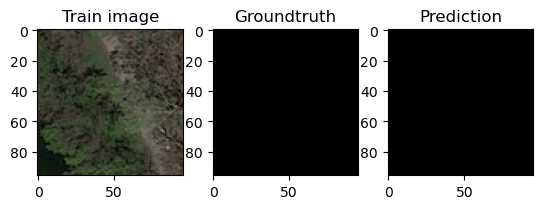

In [ ]:
patch_you_want_to_see = 1
pred_threshold = 0.2

fig, ax = plt.subplots(1,3)

ax[0].imshow(X_train[patch_you_want_to_see])
ax[0].title.set_text('Train image')
ax[1].imshow(y_train[patch_you_want_to_see], cmap="gray")
ax[1].title.set_text('Groundtruth')

prediction = MODEL.predict(X_train[patch_you_want_to_see][np.newaxis, :, :, :]) # Need to add an axis in front as mode expects batch
prediction = (prediction > pred_threshold).astype(np.uint8) # Transforms continuous values into 0-1

ax[2].imshow(prediction[0], cmap="gray")
ax[2].title.set_text('Prediction')


### Check test images

In [ ]:
image_you_want_to_see = 0
patch_side_len = 7 # DEPENDS ON SIZE OF IMAGE AND PATCHSIZE
pred_threshold = 0.2

test_image_side_len = patch_side_len * PATCH_SIZE
reconstructed_image = np.zeros((test_image_side_len, test_image_side_len, 3))
reconstructed_gt = np.zeros((test_image_side_len, test_image_side_len, 1))

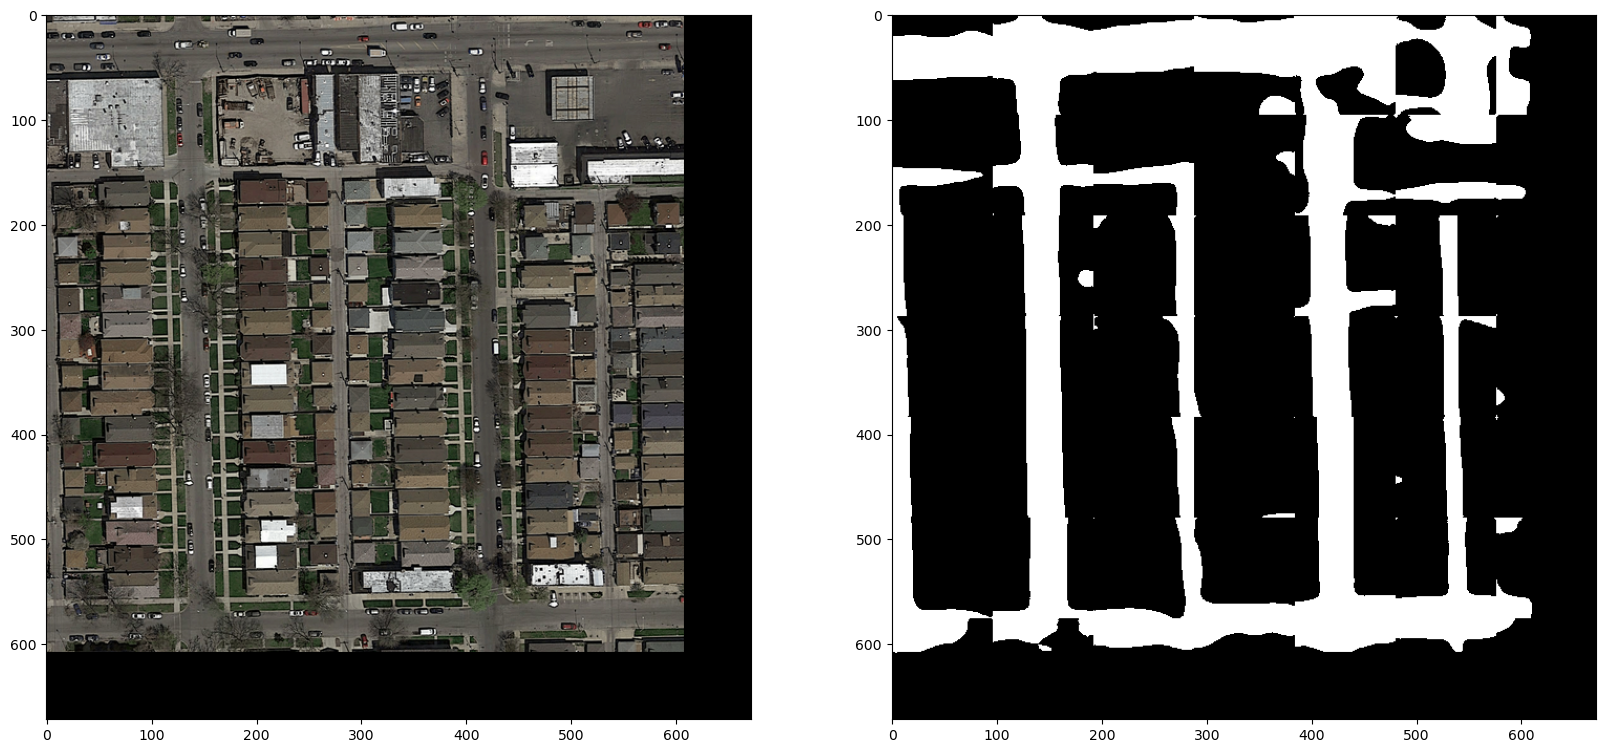

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(20,30))
for i in range(patch_side_len*image_you_want_to_see,patch_side_len*image_you_want_to_see + patch_side_len):
    for j in range(patch_side_len):
        reconstructed_image[(i-patch_side_len*image_you_want_to_see)*PATCH_SIZE : (i-patch_side_len*image_you_want_to_see)*PATCH_SIZE + PATCH_SIZE, j*PATCH_SIZE : j*PATCH_SIZE + PATCH_SIZE] = test_images[patch_side_len*i + j]

#reconstructed_image = cv2.resize(reconstructed_image, [2880, 1620])
ax[0].imshow(reconstructed_image)

for i in range(patch_side_len*image_you_want_to_see,patch_side_len*image_you_want_to_see + patch_side_len):
    for j in range(patch_side_len):
        prediction = MODEL.predict(test_images[patch_side_len*i + j][np.newaxis, :, :, :], verbose = False)
        prediction = (prediction > pred_threshold).astype(np.uint8)
        reconstructed_gt[(i-patch_side_len*image_you_want_to_see)*PATCH_SIZE : (i-patch_side_len*image_you_want_to_see)*PATCH_SIZE + PATCH_SIZE, j*PATCH_SIZE : j*PATCH_SIZE + PATCH_SIZE] = prediction[0]

#reconstructed_gt = cv2.resize(reconstructed_gt, [2880, 1620])
ax[1].imshow(reconstructed_gt, cmap='gray')

#plt.savefig('galatsi_unet_uavid.png', dpi=96)

## Save submission

In [ ]:
MODEL = tf.keras.models.load_model(SAVE_MODEL_PATH, custom_objects={'get_f1': get_f1})

In [ ]:
test_predictions = MODEL.predict(test_images)

77/77 [==============================] - 131s 2s/step


In [ ]:
submission_thres = 0.2
prediction_to_csv(test_predictions, test_ids, PATCH_SIZE, submission_thres)